# Housekeeping (Importing libraries, loading datasets)

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import qmc
from scipy.stats import norm

In [2]:
# secured overnight financing rate, sourced from the st. louis fred
sofr = pd.read_csv('data/FRED_SOFR.csv', parse_dates=['DATE'], index_col='DATE')

In [3]:
sofr.head()

,SOFR
DATE,
2018-04-03,1.83
2018-04-04,1.74
2018-04-05,1.75
2018-04-06,1.75
2018-04-09,1.75


In [4]:
sofr.tail()

,SOFR
DATE,
2024-10-28,4.82
2024-10-29,4.82
2024-10-30,4.81
2024-10-31,4.9
2024-11-01,4.86


In [5]:
# Load Market Yield on U.S. Treasury Securities at X-Year Constant Maturity, Quoted on an Investment Basis
dgs1 = pd.read_csv('data/DGS1.csv', parse_dates=['DATE'], index_col='DATE')
dgs2 = pd.read_csv('data/DGS2.csv', parse_dates=['DATE'], index_col='DATE')
dgs5 = pd.read_csv('data/DGS5.csv', parse_dates=['DATE'], index_col='DATE')
dgs10 = pd.read_csv('data/DGS10.csv', parse_dates=['DATE'], index_col='DATE')
dgs30 = pd.read_csv('data/DGS30.csv', parse_dates=['DATE'], index_col='DATE')

# combine them all
yc = pd.concat([dgs1.rename(columns={'DGS1': '1Y'}),
                              dgs2.rename(columns={'DGS2': '2Y'}),
                              dgs5.rename(columns={'DGS5': '5Y'}),
                              dgs10.rename(columns={'DGS10': '10Y'}),
                              dgs30.rename(columns={'DGS30': '30Y'})], axis=1)

In [6]:
yc.head()

,1Y,2Y,5Y,10Y,30Y
DATE,,,,,
1962-01-02,3.22,NaN,3.88,4.06,NaN
1962-01-03,3.24,NaN,3.87,4.03,NaN
1962-01-04,3.24,NaN,3.86,3.99,NaN
1962-01-05,3.26,NaN,3.89,4.02,NaN
1962-01-08,3.31,NaN,3.91,4.03,NaN


In [7]:
yc.tail()

,1Y,2Y,5Y,10Y,30Y
DATE,,,,,
2024-10-25,4.29,4.11,4.07,4.25,4.51
2024-10-28,4.28,4.12,4.11,4.28,4.53
2024-10-29,4.29,4.11,4.11,4.28,4.52
2024-10-30,4.28,4.15,4.14,4.29,4.49
2024-10-31,4.27,4.16,4.15,4.28,4.47


# I. Exploratory Data Analysis

In [8]:
# check formissing values and prepare for imputation
print("\nMissing values in SOFR Data:", sofr.isna().sum())
print("Missing values in Yield Curve Data:", yc.isna().sum())


Missing values in SOFR Data: SOFR    0
dtype: int64
Missing values in Yield Curve Data: 1Y        0
2Y     3760
5Y        0
10Y       0
30Y    3945
dtype: int64


In [9]:
print("\nSOFR Summary Statistics:")
print(sofr.describe())


SOFR Summary Statistics:
        SOFR
count   1719
unique   188
top     0.05
freq     188


In [10]:
print("\nYield Curve Summary Statistics:")
print(yc.describe())


Yield Curve Summary Statistics:
           1Y     2Y     5Y    10Y    30Y
count   16393  12633  16393  16393  12448
unique   1896   1873   1468   1403   1323
top         .      .      .      .      .
freq      698    530    698    698    523


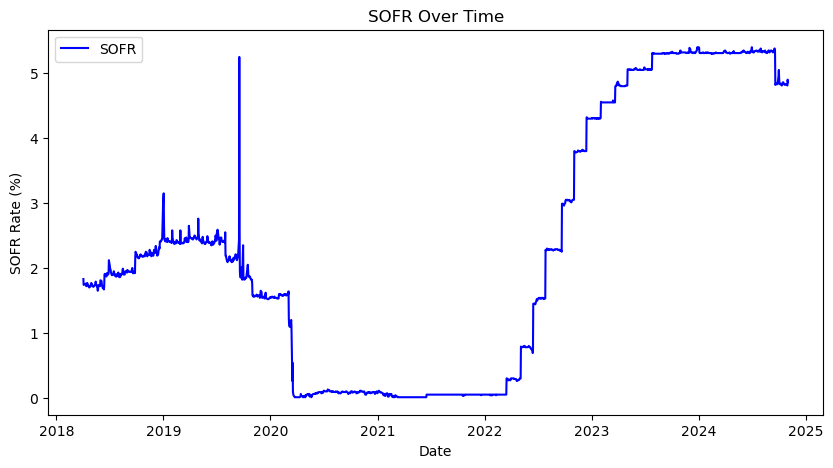

In [11]:
# Ensure SOFR data is numeric and drop any non-numeric rows (if any)
sofr['SOFR'] = pd.to_numeric(sofr['SOFR'], errors='coerce')
sofr = sofr.dropna()  # Drop rows where SOFR might be NaN after conversion

# Plot SOFR over time
plt.figure(figsize=(10, 5))
plt.plot(sofr.index, sofr['SOFR'], label='SOFR', color='blue')
plt.title("SOFR Over Time")
plt.xlabel("Date")
plt.ylabel("SOFR Rate (%)")
plt.legend()
plt.show()

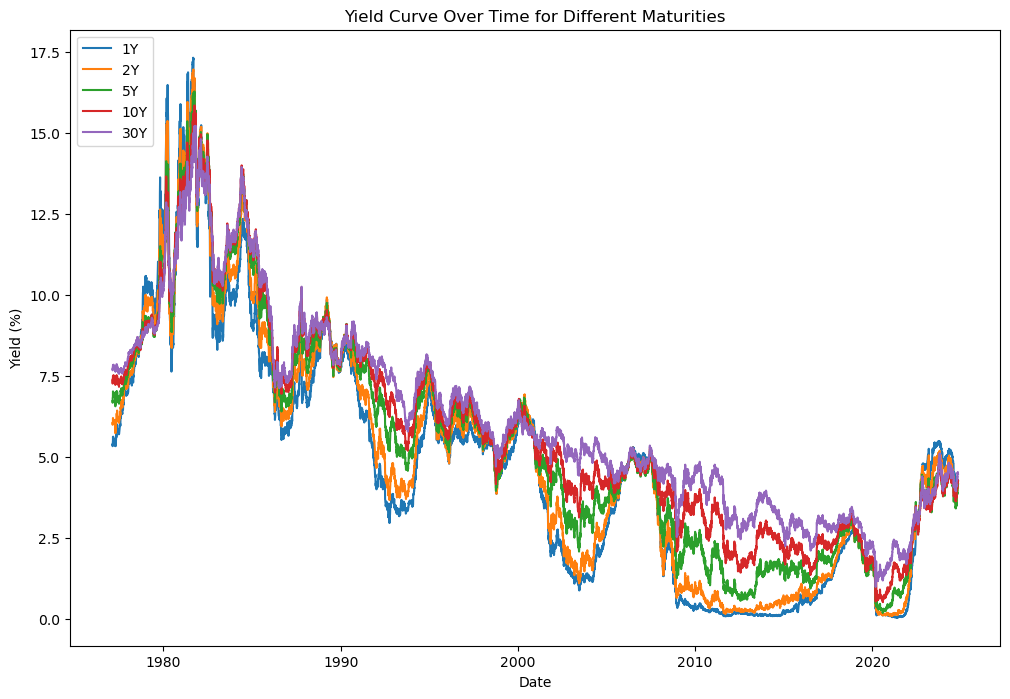

In [12]:
# Ensure all yield curve columns are numeric and handle any non-numeric values
for col in yc.columns:
    yc[col] = pd.to_numeric(yc[col], errors='coerce')

# Drop rows with NaN values or interpolate
yc = yc.interpolate(method='time').dropna()  # Interpolate missing values based on time index

# Plot yield curve maturities
plt.figure(figsize=(12, 8))
for col in yc.columns:
    plt.plot(yc.index, yc[col], label=col)
    
plt.title("Yield Curve Over Time for Different Maturities")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.legend(loc='upper left')
plt.show()

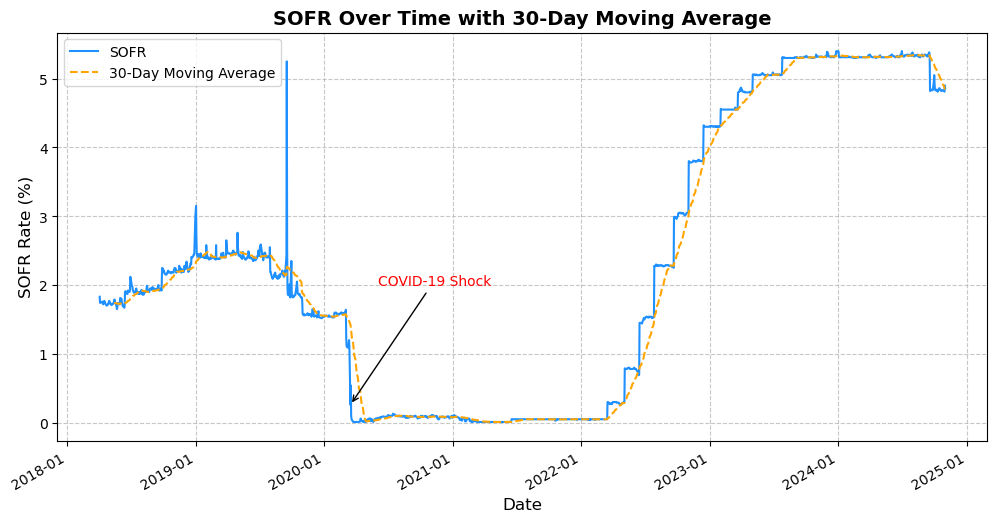

In [13]:
# Ensure SOFR data is numeric and drop any non-numeric rows (if any)
sofr['SOFR'] = pd.to_numeric(sofr['SOFR'], errors='coerce')
sofr = sofr.dropna()  # Drop rows where SOFR might be NaN after conversion

# Calculate a 30-day moving average for SOFR
sofr['SOFR_MA'] = sofr['SOFR'].rolling(window=30).mean()

# Set up the plot
plt.figure(figsize=(12, 6))
plt.plot(sofr.index, sofr['SOFR'], label='SOFR', color='dodgerblue')
plt.plot(sofr.index, sofr['SOFR_MA'], label='30-Day Moving Average', color='orange', linestyle='--')

# Convert annotation date to datetime format
annot_date = datetime(2020, 3, 16)  # Example annotation date for COVID-19

# Annotating a significant date (COVID-19 impact on rates as an example)
plt.annotate('COVID-19 Shock', 
             xy=(annot_date, sofr.loc[annot_date, 'SOFR']), 
             xytext=(datetime(2020, 6, 1), 2.0),
             arrowprops=dict(facecolor='red', arrowstyle='->'), color='red')

# Beautify the plot
plt.title("SOFR Over Time with 30-Day Moving Average", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("SOFR Rate (%)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Formatting the x-axis to show year and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Show ticks every year
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.show()

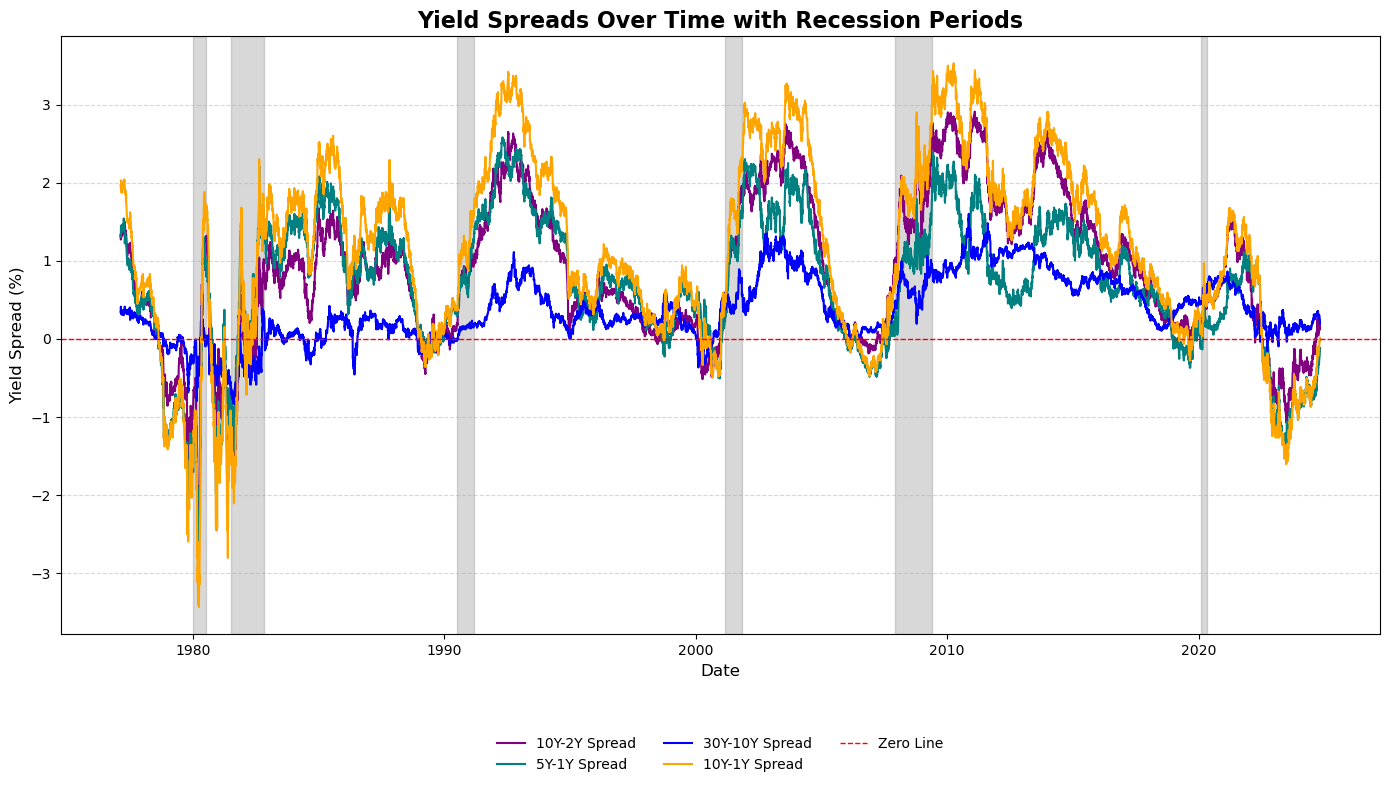

In [16]:
recession_periods = [
    ('1969-12-01', '1970-11-01'),
    ('1973-11-01', '1975-03-01'),
    ('1980-01-01', '1980-07-01'),
    ('1981-07-01', '1982-11-01'),
    ('1990-07-01', '1991-03-01'),
    ('2001-03-01', '2001-11-01'),
    ('2007-12-01', '2009-06-01'),
    ('2020-02-01', '2020-05-01')  # COVID-19 recession
]

# Define the start date for plotting
start_date = '1975-01-01'

# Filter data starting from the specified start date
filtered_yc = yc[yc.index >= start_date]

# Calculate yield spreads if not already calculated
filtered_yc['10Y-2Y Spread'] = filtered_yc['10Y'] - filtered_yc['2Y']
filtered_yc['5Y-1Y Spread'] = filtered_yc['5Y'] - filtered_yc['1Y']
filtered_yc['30Y-10Y Spread'] = filtered_yc['30Y'] - filtered_yc['10Y']
filtered_yc['10Y-1Y Spread'] = filtered_yc['10Y'] - filtered_yc['1Y']

# Create the plot with enhanced styling
plt.figure(figsize=(14, 8))

# Plot each spread with different styles and colors
plt.plot(filtered_yc.index, filtered_yc['10Y-2Y Spread'], color='purple', label='10Y-2Y Spread')
plt.plot(filtered_yc.index, filtered_yc['5Y-1Y Spread'], color='teal', label='5Y-1Y Spread')
plt.plot(filtered_yc.index, filtered_yc['30Y-10Y Spread'], color='blue', label='30Y-10Y Spread')
plt.plot(filtered_yc.index, filtered_yc['10Y-1Y Spread'], color='orange', label='10Y-1Y Spread')

# Add a horizontal line at zero to indicate spread inversion
plt.axhline(0, color='red', linestyle='--', label='Zero Line', linewidth=1)

# Mark recession periods with shaded regions
for start, end in recession_periods:
    if start >= start_date:  # Only mark recessions within the filtered date range
        plt.axvspan(start, end, color='gray', alpha=0.3)

# Enhance plot aesthetics
plt.title("Yield Spreads Over Time with Recession Periods", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Yield Spread (%)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Only show horizontal grid lines to reduce clutter

# Adjust legend positioning
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10, frameon=False)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()

are all these spreads required to be plotted? whats the significance?

# Random Number Generation

# II: Construction of Forward Rate Curves

Forward Rate Curve:
               1Y-2Y     2Y-5Y    5Y-10Y   10Y-30Y
DATE                                              
1977-02-15  6.694009  7.175754  8.003838  7.870404
1977-02-16  6.643647  7.155755  7.983839  7.835380
1977-02-17  6.654136  7.125755  7.853263  7.875587
1977-02-18  6.744388  7.329690  8.003259  7.935427
1977-02-21  6.728915  7.339630  8.003176  7.942927


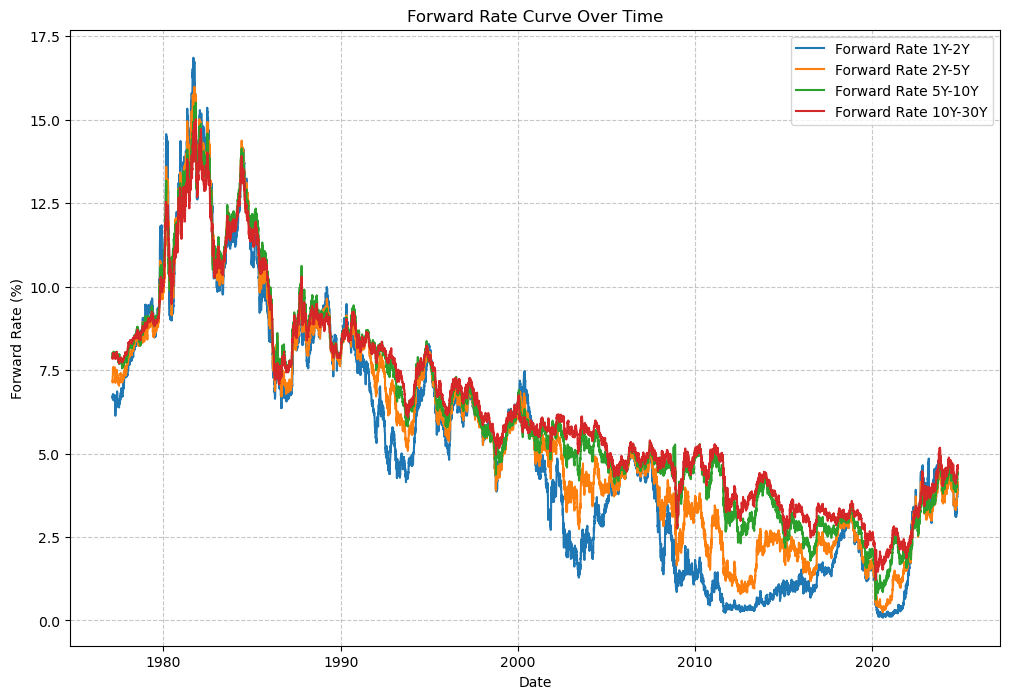

In [17]:
# Define a function to calculate forward rates between consecutive maturities
def calculate_forward_rate(yield_curve, t1, t2):
    """
    Calculate the forward rate between two maturities, t1 and t2.
    yield_curve: DataFrame containing spot rates for different maturities.
    t1, t2: Two consecutive maturities in years (e.g., 1, 2, 5, 10, 30).
    """
    # Spot rates for maturities t1 and t2
    r_t1 = yield_curve[f"{t1}Y"]
    r_t2 = yield_curve[f"{t2}Y"]
    
    # Calculate forward rate
    forward_rate = ((1 + r_t2 / 100) ** t2 / (1 + r_t1 / 100) ** t1) ** (1 / (t2 - t1)) - 1
    return forward_rate * 100  # Convert to percentage

# Calculate forward rates for consecutive pairs of maturities
forward_curve = pd.DataFrame(index=yc.index)
forward_curve['1Y-2Y'] = calculate_forward_rate(yc, 1, 2)
forward_curve['2Y-5Y'] = calculate_forward_rate(yc, 2, 5)
forward_curve['5Y-10Y'] = calculate_forward_rate(yc, 5, 10)
forward_curve['10Y-30Y'] = calculate_forward_rate(yc, 10, 30)

# Display the calculated forward rate curve
print("Forward Rate Curve:")
print(forward_curve.head())

# Plot the forward rate curves over time
plt.figure(figsize=(12, 8))
for column in forward_curve.columns:
    plt.plot(forward_curve.index, forward_curve[column], label=f"Forward Rate {column}")

plt.title("Forward Rate Curve Over Time")
plt.xlabel("Date")
plt.ylabel("Forward Rate (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# III. Dimensionality Reduction/Analysis of Yield Curve Movements using PCA

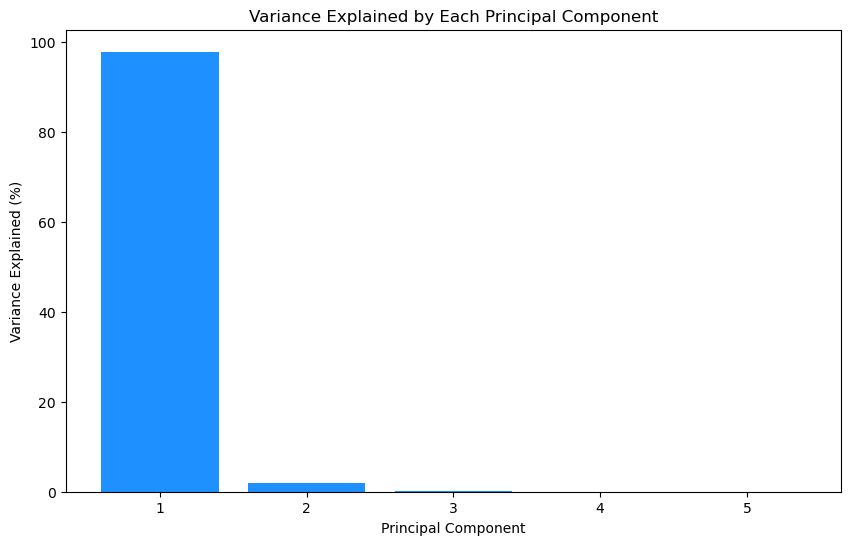

In [18]:
# Select the yield curve columns (e.g., 1Y, 2Y, 5Y, 10Y, 30Y)
yield_data = yc[['1Y', '2Y', '5Y', '10Y', '30Y']]

# Standardize the data
scaler = StandardScaler()
yield_data_std = scaler.fit_transform(yield_data)

# Apply PCA
pca = PCA(n_components=5)  # Adjust number of components as needed
pca.fit(yield_data_std)
yield_pca = pca.transform(yield_data_std)

# Explained variance by each component
explained_variance = pca.explained_variance_ratio_

# Plot the variance explained by each component
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100, color='dodgerblue')
plt.title("Variance Explained by Each Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.show()

We see that most of the variance has been captured by the first PC. With the rest being captured by 2 and 3.

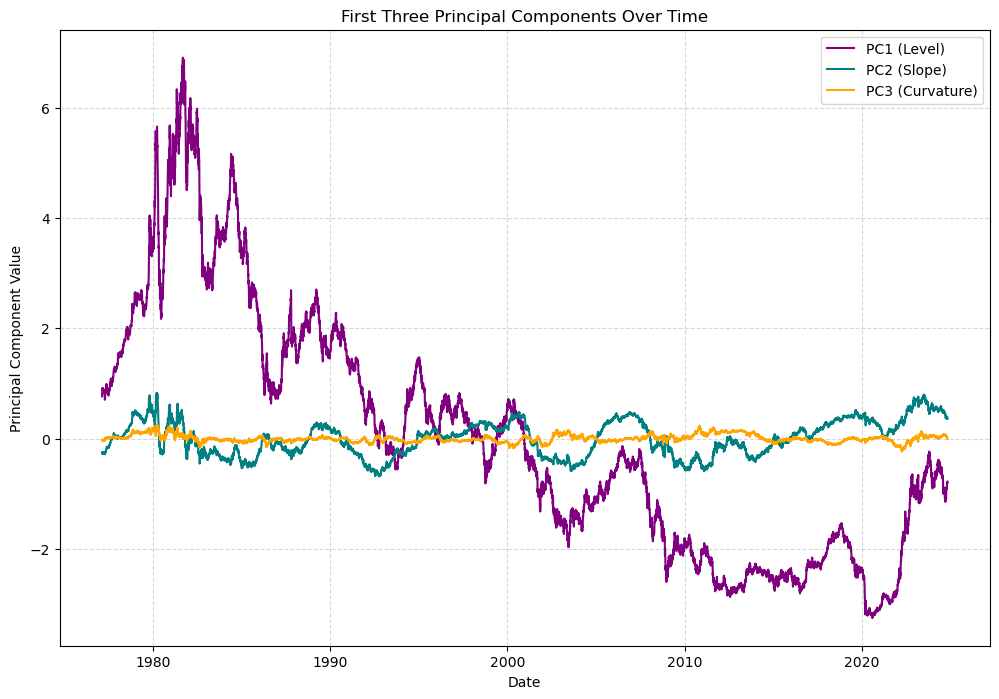

In [19]:
# Convert the PCA components to a DataFrame for further analysis
pca_df = pd.DataFrame(yield_pca, index=yield_data.index, columns=[f'PC{i+1}' for i in range(yield_pca.shape[1])])

# Plot the first three principal components over time to analyze level, slope, and curvature
plt.figure(figsize=(12, 8))
plt.plot(pca_df.index, pca_df['PC1'], label='PC1 (Level)', color='purple')
plt.plot(pca_df.index, pca_df['PC2'], label='PC2 (Slope)', color='teal')
plt.plot(pca_df.index, pca_df['PC3'], label='PC3 (Curvature)', color='orange')
plt.title("First Three Principal Components Over Time")
plt.xlabel("Date")
plt.ylabel("Principal Component Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

The principal components are used to calibrate the volatility structure of the HJM model. This ensures that the stochastic simulation of forward rates reflects historical yield curve dynamics. Each PC is associated with a factor in the HJM model, which influences how forward rates evolve over time.

# IV: Stochastic Modeling with the HJM Framework

In [20]:
# add custom implementation of random number generation (experiment with multiplle methods, starting with normal distribution)
# + sobol etc

In [21]:
# Define parameters for the simulation
n_steps = 100  # Number of time steps
n_simulations = 10  # Number of simulation paths
dt = 1/252  # Time step (assuming 252 trading days per year)
volatility = 0.01  # Constant volatility (1%)

Columns in yc: Index(['1Y', '2Y', '5Y', '10Y', '30Y'], dtype='object')


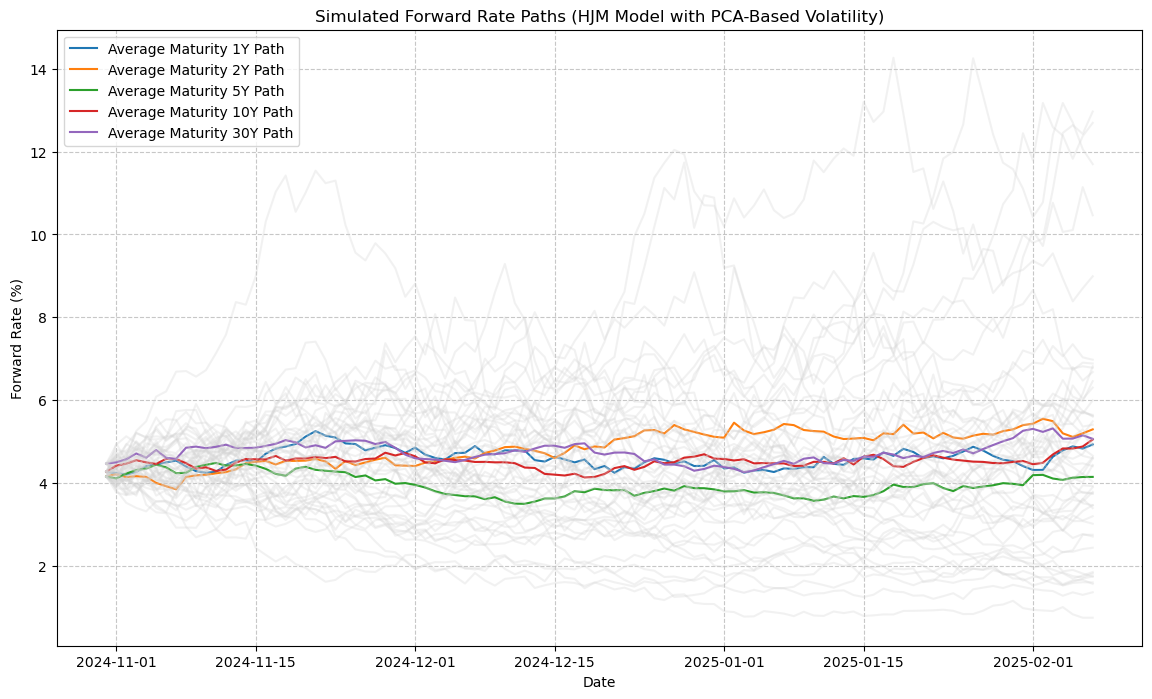

In [37]:
# Define parameters for the simulation
n_steps = 100  # Number of time steps
n_simulations = 10  # Number of simulation paths
dt = 1 / 252  # Time step (assuming 252 trading days per year)

# Use yc for spot rates if forward_curve doesn't have the required columns
print("Columns in yc:", yc.columns)

# Define available maturities in yc (spot rates)
available_maturities = ['1Y', '2Y', '5Y', '10Y', '30Y']  # Adjust based on actual columns in yc

# Initialize forward rate curve from the last available spot rates in yc
initial_forward_rates = yc[available_maturities].iloc[-1].values  # Use the last row of spot rates
n_maturities = len(initial_forward_rates)

# Initialize array to store simulated forward rate paths
simulated_forward_rates = np.zeros((n_steps, n_maturities, n_simulations))

# Set the initial forward rates as the starting point for each path
simulated_forward_rates[0, :, :] = initial_forward_rates[:, np.newaxis]

# Function to calculate volatility using PCA results
def calculate_volatility(t, T_index, eigenvectors, eigenvalues, n_factors=3):
    """
    Calculate volatility for maturity T using PCA-derived eigenvectors and eigenvalues.
    :param t: Current time step
    :param T_index: Index of maturity in the available maturities list
    :param eigenvectors: PCA eigenvectors
    :param eigenvalues: PCA eigenvalues
    :param n_factors: Number of principal components to use
    :return: Volatility for the maturity T at time t
    """
    volatility = 0
    for i in range(min(n_factors, len(eigenvalues))):  # Use up to n_factors components
        volatility += eigenvectors[i, T_index] * np.sqrt(eigenvalues[i])
    return volatility

# Simulate forward rate paths using the HJM Model with PCA-based volatility
for i in range(1, n_steps):
    dW = np.random.normal(0, np.sqrt(dt), (n_maturities, n_simulations))  # Custom implementation for random numbers can be substituted here
    
    for j in range(n_maturities):  # Loop over maturities
        # Calculate volatility for the current maturity using PCA results
        volatility = calculate_volatility(i * dt, j, pca.components_, pca.explained_variance_)
        
        drift = 0  # Simplified drift; a complex drift can incorporate PCA dynamics or other market factors
        diffusion = volatility * dW[j, :]
        
        # Update forward rates
        simulated_forward_rates[i, j, :] = simulated_forward_rates[i-1, j, :] * np.exp(drift * dt + diffusion)

# Convert results to DataFrame for analysis and plotting
dates = pd.date_range(start=yc.index[-1], periods=n_steps, freq='D')
simulated_paths = {f'Maturity {m}Y': pd.DataFrame(simulated_forward_rates[:, j, :], index=dates) for j, m in enumerate([1, 2, 5, 10, 30])}

# Plotting simulated forward rate paths
plt.figure(figsize=(14, 8))
for maturity, paths in simulated_paths.items():
    plt.plot(paths.index, paths.mean(axis=1), label=f"Average {maturity} Path")
    for path in paths.columns:
        plt.plot(paths.index, paths[path], color='lightgray', alpha=0.3)

plt.title("Simulated Forward Rate Paths (HJM Model with PCA-Based Volatility)")
plt.xlabel("Date")
plt.ylabel("Forward Rate (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [24]:
# Initialize the Sobol generator for quasi-random numbers
sobol_gen = qmc.Sobol(d=n_maturities * n_simulations, scramble=True)
sobol_sequence = sobol_gen.random(n_steps)

/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/scipy/stats/_qmc.py:804: UserWarning:

The balance properties of Sobol' points require n to be a power of 2.



In [26]:
# Simulation loop for HJM with Sobol-based random shocks
for i in range(1, n_steps):
    # Get Sobol quasi-random numbers and transform them to standard normal
    sobol_shocks = norm.ppf(sobol_sequence[i, :].reshape(n_maturities, n_simulations))
    
    # Drift remains the same; diffusion now uses Sobol shocks
    drift = 0  # Simplified drift for illustration; could be expanded as before
    diffusion = volatility * sobol_shocks
    
    # Update forward rates using the Sobol sequence-based diffusion term
    simulated_forward_rates[i, :, :] = simulated_forward_rates[i-1, :, :] * np.exp(drift * dt + diffusion)

# COMPUTATIONAL TIME COMPARISON

# V. Pricing IR Derivatives

In [25]:
# Define parameters for the cap and floor pricing
cap_rate = 0.03  # Example cap rate (3%)
floor_rate = 0.02  # Example floor rate (2%)
discount_rate = 0.01
maturities = np.array([1, 2, 5, 10, 30])

# Simulation parameters (as used in the HJM model)
n_steps = 100  # Number of time steps
n_simulations = 10  # Number of simulation paths
dt = 1 / 252  # Time step (assuming 252 trading days in a year)

# Initialize arrays to store cumulative payoffs for cap and floor
cap_payoffs = np.zeros((n_steps, n_simulations))
floor_payoffs = np.zeros((n_steps, n_simulations))

for i in range(1, n_steps):
    for j in range(n_simulations):
        for k, T in enumerate(maturities[:-1]):  # Loop over maturities (caplet intervals)
            # Calculate forward rate between maturities T and T+1
            fwd_rate = simulated_forward_rates[i, k, j]

            # Caplet payoff (only if fwd_rate exceeds cap rate)
            caplet_payoff = max(fwd_rate - cap_rate, 0)
            cap_payoffs[i, j] += caplet_payoff

            # Floorlet payoff (only if fwd_rate is below floor rate)
            floorlet_payoff = max(floor_rate - fwd_rate, 0)
            floor_payoffs[i, j] += floorlet_payoff

# Calculate the average payoff across all simulation paths
average_cap_payoffs = np.mean(cap_payoffs, axis=1)
average_floor_payoffs = np.mean(floor_payoffs, axis=1)

# Discount payoffs back to present value
cap_price = np.sum(average_cap_payoffs * np.exp(-discount_rate * np.arange(1, n_steps+1) * dt))
floor_price = np.sum(average_floor_payoffs * np.exp(-discount_rate * np.arange(1, n_steps+1) * dt))

print(f"Cap Price: {cap_price:.4f}")
print(f"Floor Price: {floor_price:.4f}")

Cap Price: 1653.2709
Floor Price: 0.0000


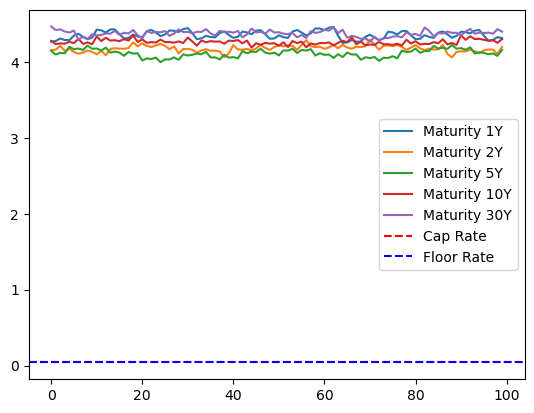

In [31]:
for maturity in range(simulated_forward_rates.shape[1]):
    plt.plot(simulated_forward_rates[:, maturity, 0], label=f"Maturity {maturities[maturity]}Y")
plt.axhline(cap_rate, color='red', linestyle='--', label="Cap Rate")
plt.axhline(floor_rate, color='blue', linestyle='--', label="Floor Rate")
plt.legend()
plt.show()

# VI. Sensitivity Analysis

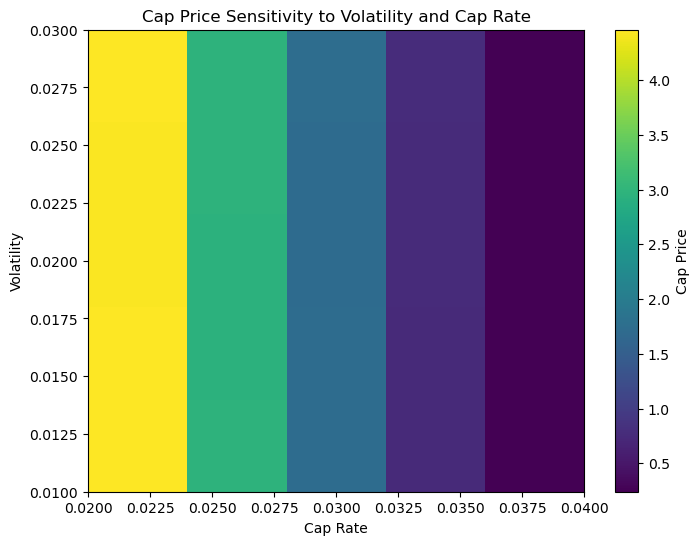

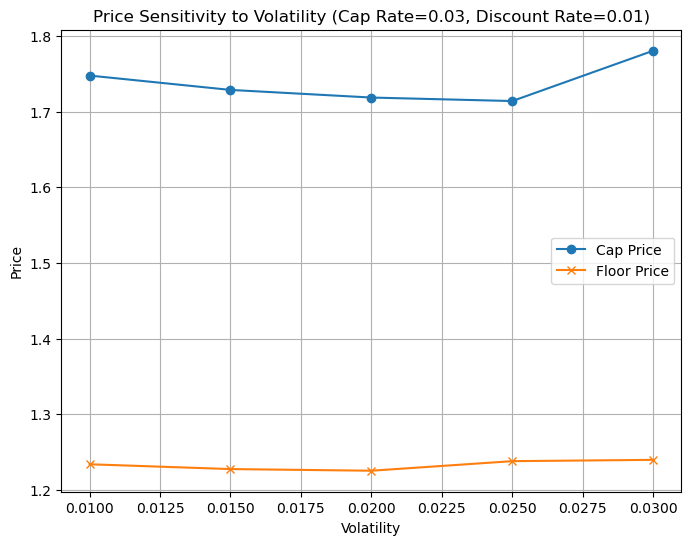

In [29]:
# Parameters for sensitivity analysis
volatility_range = np.linspace(0.01, 0.03, 5)  # Volatility from 1% to 3%
cap_rate_range = np.linspace(0.02, 0.04, 5)  # Cap/Floor rates from 2% to 4%
discount_rate_range = np.linspace(0.005, 0.02, 4)  # Discount rates from 0.5% to 2%

# Fixed simulation parameters (as used in the base model)
n_steps = 100
n_simulations = 10
dt = 1 / 252
maturities = np.array([1, 2, 5, 10, 30])  # Maturities in years

# Placeholder for sensitivity results
sensitivity_results = []

# Function to calculate cap and floor prices
def calculate_prices(volatility, cap_rate, floor_rate, discount_rate):
    # Simulate forward rates (using the HJM framework from prior work)
    simulated_forward_rates = np.zeros((n_steps, len(maturities), n_simulations))
    simulated_forward_rates[0, :, :] = np.linspace(0.02, 0.05, len(maturities))[:, np.newaxis]  # Example initial rates
    
    for i in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt), (len(maturities), n_simulations))
        diffusion = volatility * dW
        simulated_forward_rates[i, :, :] = simulated_forward_rates[i-1, :, :] * np.exp(diffusion)
    
    # Calculate payoffs
    cap_payoffs = np.zeros((n_steps, n_simulations))
    floor_payoffs = np.zeros((n_steps, n_simulations))
    
    for i in range(1, n_steps):
        for j in range(n_simulations):
            for k in range(len(maturities) - 1):
                fwd_rate = simulated_forward_rates[i, k, j]
                cap_payoffs[i, j] += max(fwd_rate - cap_rate, 0)
                floor_payoffs[i, j] += max(floor_rate - fwd_rate, 0)
    
    # Discount payoffs
    average_cap_payoff = np.mean(cap_payoffs, axis=1)
    average_floor_payoff = np.mean(floor_payoffs, axis=1)
    cap_price = np.sum(average_cap_payoff * np.exp(-discount_rate * np.arange(1, n_steps + 1) * dt))
    floor_price = np.sum(average_floor_payoff * np.exp(-discount_rate * np.arange(1, n_steps + 1) * dt))
    
    return cap_price, floor_price

# Perform sensitivity analysis
for volatility in volatility_range:
    for cap_rate in cap_rate_range:
        for discount_rate in discount_rate_range:
            floor_rate = cap_rate  # Assume floor rate equals cap rate for simplicity
            cap_price, floor_price = calculate_prices(volatility, cap_rate, floor_rate, discount_rate)
            sensitivity_results.append({
                'Volatility': volatility,
                'Cap Rate': cap_rate,
                'Discount Rate': discount_rate,
                'Cap Price': cap_price,
                'Floor Price': floor_price
            })

# Convert results to DataFrame for analysis and visualization
sensitivity_df = pd.DataFrame(sensitivity_results)

# Visualize sensitivity analysis
# Example 1: Heatmap of Cap Prices vs. Volatility and Cap Rate
pivot = sensitivity_df.pivot_table(index="Volatility", columns="Cap Rate", values="Cap Price")
plt.figure(figsize=(8, 6))
plt.title("Cap Price Sensitivity to Volatility and Cap Rate")
plt.xlabel("Cap Rate")
plt.ylabel("Volatility")
plt.imshow(pivot, cmap='viridis', aspect='auto', origin='lower', extent=[
    cap_rate_range.min(), cap_rate_range.max(),
    volatility_range.min(), volatility_range.max()
])
plt.colorbar(label="Cap Price")
plt.show()

# Example 2: Line Plot of Cap Price vs. Volatility (for fixed cap rate and discount rate)
fixed_cap_rate = 0.03
fixed_discount_rate = 0.01
subset = sensitivity_df[(sensitivity_df['Cap Rate'] == fixed_cap_rate) &
                        (sensitivity_df['Discount Rate'] == fixed_discount_rate)]
plt.figure(figsize=(8, 6))
plt.plot(subset['Volatility'], subset['Cap Price'], marker='o', label="Cap Price")
plt.plot(subset['Volatility'], subset['Floor Price'], marker='x', label="Floor Price")
plt.title(f"Price Sensitivity to Volatility (Cap Rate={fixed_cap_rate}, Discount Rate={fixed_discount_rate})")
plt.xlabel("Volatility")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()